In [6]:
# Cell 1
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_fscore_support

from imblearn.over_sampling import SMOTE

# Try to import lightgbm (optional)
try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except Exception:
    LIGHTGBM_AVAILABLE = False

# Configuration
TRAIN_PATH = "./processed/train.csv"
TEST_PATH  = "./processed/test.csv"
OUT_DIR    = "./models_compare"
os.makedirs(OUT_DIR, exist_ok=True)

# features to drop (leaks discovered earlier)
LEAKS = ["overlap_flag", "speed_violation", "sybil_cluster_score", "witness_score", "witness_count", "neighbor_reliability"]
SAMPLE_N = 2000000   # working sample size for SMOTE/training (None => use full training set; may be heavy)
RANDOM_STATE = 42
print("LIGHTGBM_AVAILABLE:", LIGHTGBM_AVAILABLE)


LIGHTGBM_AVAILABLE: True


In [7]:
# Cell 2
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
print("Train shape:", train.shape, "Test shape:", test.shape)
print("Original train label counts:\n", train["label"].value_counts())

# Prepare feature matrices
drop_cols = [c for c in LEAKS if c in train.columns]
if "time" in train.columns:
    drop_cols += ["time"]

X_full = train.drop(columns=["label"] + ([c for c in drop_cols if c in train.columns]))
y_full = train["label"].copy()

X_test = test.drop(columns=["label"] + (["time"] if "time" in test.columns else []))
y_test = test["label"].copy()
# drop leaks from test as well
X_test = X_test.drop(columns=[c for c in LEAKS if c in X_test.columns], errors="ignore")

print("Features after drop:", X_full.shape[1])


Train shape: (2085071, 21) Test shape: (893603, 21)
Original train label counts:
 label
0    2083425
1       1646
Name: count, dtype: int64
Features after drop: 13


In [8]:
# Cell 3
# Stratified sample to keep class ratio (for speed & memory). Set SAMPLE_N = None to use full set (can be very slow).
if SAMPLE_N is not None and SAMPLE_N < len(X_full):
    X_sample, _, y_sample, _ = \
        __import__("sklearn.model_selection", fromlist=["train_test_split"]).train_test_split(
            X_full, y_full, train_size=SAMPLE_N, stratify=y_full, random_state=RANDOM_STATE)
else:
    X_sample = X_full.copy()
    y_sample = y_full.copy()

print("Sample size:", len(X_sample), "Label counts:", y_sample.value_counts().to_dict())

# numeric columns (assume mostly numeric)
num_cols = X_sample.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns (n={}): {}".format(len(num_cols), num_cols[:20]))

scaler = StandardScaler()
X_sample[num_cols] = scaler.fit_transform(X_sample[num_cols])
# save scaler
with open(os.path.join(OUT_DIR, "scaler_for_compare.pkl"), "wb") as f:
    pickle.dump(scaler, f)

# SMOTE
sm = SMOTE(random_state=RANDOM_STATE)
print("Running SMOTE on sample (this may take a minute)...")
t0 = time()
X_res, y_res = sm.fit_resample(X_sample, y_sample)
print("SMOTE done. time: {:.1f}s. After SMOTE shape:".format(time()-t0), X_res.shape, pd.Series(y_res).value_counts().to_dict())


Sample size: 2000000 Label counts: {0: 1998421, 1: 1579}
Numeric columns (n=13): ['x', 'y', 'reported_speed_mps', 'heading_deg', 'displacement_m', 'implied_speed_mps', 'acceleration', 'velocity_consistency_abs_diff', 'neighbor_diversity_window', 'rssi_dbm_mean', 'speed_diff_mps', 'speed_diff_ratio', 'trajectory_smoothness']
Running SMOTE on sample (this may take a minute)...
SMOTE done. time: 2.9s. After SMOTE shape: (3996842, 13) {0: 1998421, 1: 1998421}


In [10]:
# Cell 4
# Ensure numeric cols exist in test and transform
for c in num_cols:
    if c in X_test.columns:
        X_test[c] = pd.to_numeric(X_test[c], errors="coerce").fillna(0.0)
X_test[num_cols] = scaler.transform(X_test[num_cols])
print("Prepared test shape:", X_test.shape, "Test label counts:", y_test.value_counts().to_dict())


Prepared test shape: (893603, 13) Test label counts: {0: 892897, 1: 706}


In [11]:
# Cell 5
results = []
models = {}

# Helper to evaluate and record
def eval_and_record(name, model, X_trained_on=None):
    # model must be fitted
    # get probability-like scores if possible
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:,1]
    elif hasattr(model, "decision_function"):
        # decision_function can be used for AUC
        proba = model.decision_function(X_test)
    else:
        proba = model.predict(X_test)
    y_pred = model.predict(X_test)
    prf = precision_recall_fscore_support(y_test, y_pred, labels=[1], average="binary", zero_division=0)
    prec, rec, f1, _ = prf
    roc = roc_auc_score(y_test, proba)
    ap = average_precision_score(y_test, proba)
    results.append({"model": name, "precision_sybil": prec, "recall_sybil": rec, "f1_sybil": f1, "roc_auc": roc, "avg_precision": ap})
    models[name] = model
    # save model
    with open(os.path.join(OUT_DIR, f"{name}.pkl"), "wb") as f:
        pickle.dump(model, f)
    print(f"{name} done. prec={prec:.4f} rec={rec:.4f} f1={f1:.4f} roc={roc:.4f} ap={ap:.4f}")

# 1) Logistic Regression
lr = LogisticRegression(max_iter=200, class_weight="balanced", solver="saga", n_jobs=-1, random_state=RANDOM_STATE)
print("Training LogisticRegression...")
lr.fit(X_res, y_res)
eval_and_record("logistic_regression", lr)

# 2) Linear SVM (uses decision_function)
svm = LinearSVC(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE)
print("Training LinearSVC...")
svm.fit(X_res, y_res)
eval_and_record("linear_svc", svm)

# 3) MLP (sklearn)
mlp = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=50, random_state=RANDOM_STATE)
print("Training MLPClassifier (sklearn)...")
mlp.fit(X_res, y_res)
eval_and_record("mlp_sklearn", mlp)

# 4) LightGBM (optional)
if LIGHTGBM_AVAILABLE:
    print("Training LightGBM...")
    lgb_train = lgb.Dataset(X_res, label=y_res)
    params = {"objective":"binary", "metric":"auc", "verbosity":-1, "seed":RANDOM_STATE}
    gbm = lgb.train(params, lgb_train, num_boost_round=200)
    # wrap a simple predict function to behave like predict_proba
    class LGBWrapper:
        def __init__(self, bst): self.bst = bst
        def predict(self, X): return (self.bst.predict(X) >= 0.5).astype(int)
        def predict_proba(self, X):
            p = self.bst.predict(X)
            return np.vstack([1-p, p]).T
    lgbw = LGBWrapper(gbm)
    eval_and_record("lightgbm", lgbw)
else:
    print("LightGBM not available — skipped.")


Training LogisticRegression...


C:\Users\saiku\anaconda3\envs\vanet_py310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


logistic_regression done. prec=0.0029 rec=0.8683 f1=0.0059 roc=0.8803 ap=0.0050
Training LinearSVC...
linear_svc done. prec=0.0028 rec=0.8711 f1=0.0056 roc=0.8798 ap=0.0051
Training MLPClassifier (sklearn)...


C:\Users\saiku\anaconda3\envs\vanet_py310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


mlp_sklearn done. prec=0.0627 rec=0.4986 f1=0.1115 roc=0.9819 ap=0.0796
Training LightGBM...
lightgbm done. prec=0.0584 rec=0.7068 f1=0.1078 roc=0.9909 ap=0.1952


,precision_sybil,recall_sybil,f1_sybil,roc_auc,avg_precision
model,,,,,
mlp_sklearn,0.062745,0.498584,0.111463,0.981859,0.079556
lightgbm,0.058356,0.706799,0.107810,0.990867,0.195186
logistic_regression,0.002943,0.868272,0.005867,0.880348,0.004974
linear_svc,0.002808,0.871105,0.005598,0.879807,0.005101


<Figure size 800x500 with 0 Axes>

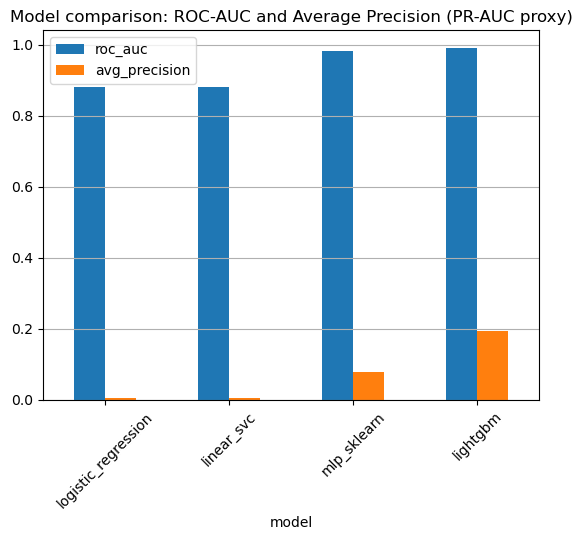

In [12]:
# Cell 6
res_df = pd.DataFrame(results).set_index("model")
display(res_df.sort_values("f1_sybil", ascending=False))

# Plot PR-AUC and ROC-AUC comparison
plt.figure(figsize=(8,5))
res_df[["roc_auc","avg_precision"]].plot.bar(rot=45)
plt.title("Model comparison: ROC-AUC and Average Precision (PR-AUC proxy)")
plt.grid(axis="y")
plt.show()


Candidate .pkl files considered for models: ['lightgbm.pkl', 'linear_svc.pkl', 'logistic_regression.pkl', 'mlp_sklearn.pkl']
Evaluated lightgbm: prec=0.0584 rec=0.7068 f1=0.1078 roc=0.9909 ap=0.1952
Evaluated linear_svc: prec=0.0028 rec=0.8711 f1=0.0056 roc=0.8798 ap=0.0051
Evaluated logistic_regression: prec=0.0029 rec=0.8683 f1=0.0059 roc=0.8803 ap=0.0050
Evaluated mlp_sklearn: prec=0.0627 rec=0.4986 f1=0.1115 roc=0.9819 ap=0.0796


,precision_sybil,recall_sybil,f1_sybil,roc_auc,avg_precision
model,,,,,
lightgbm,0.058356,0.706799,0.107810,0.990867,0.195186
linear_svc,0.002808,0.871105,0.005598,0.879807,0.005101
logistic_regression,0.002943,0.868272,0.005867,0.880348,0.004974
mlp_sklearn,0.062745,0.498584,0.111463,0.981859,0.079556


<Figure size 1200x600 with 0 Axes>

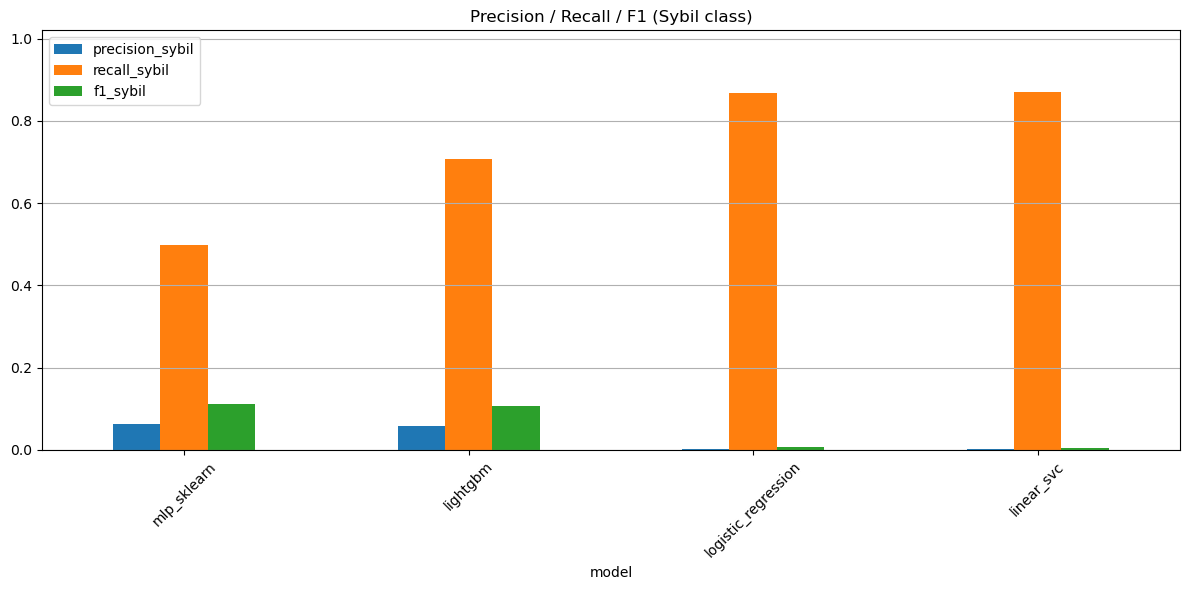

<Figure size 800x500 with 0 Axes>

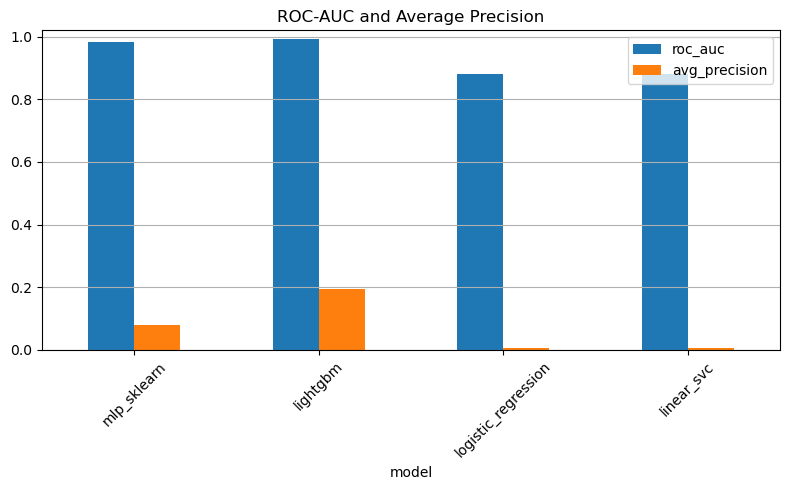

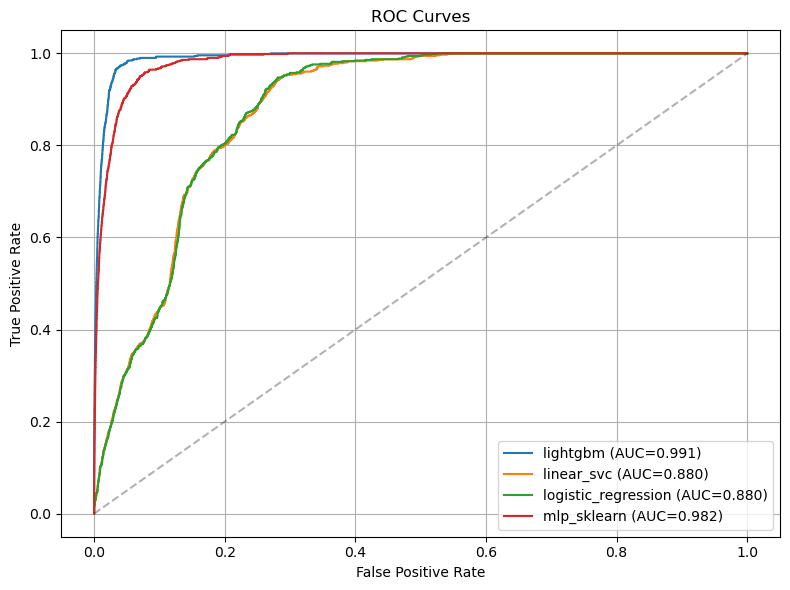

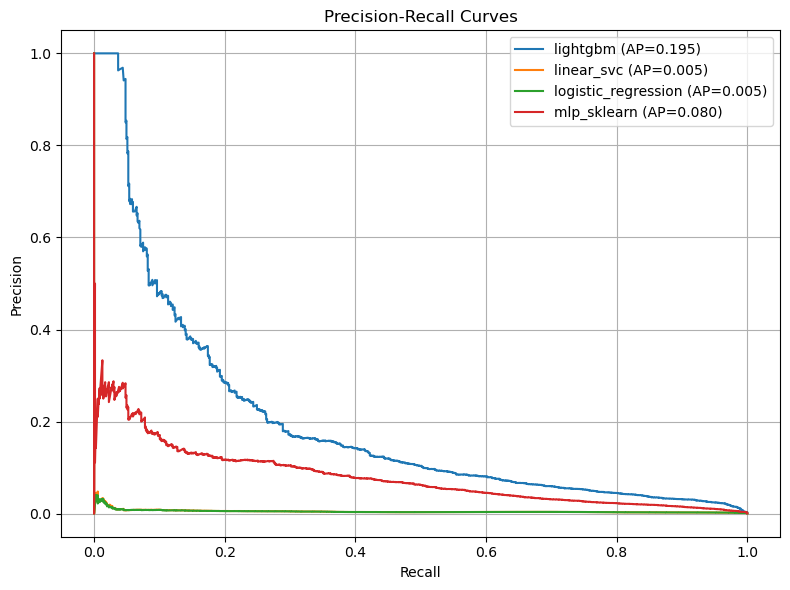

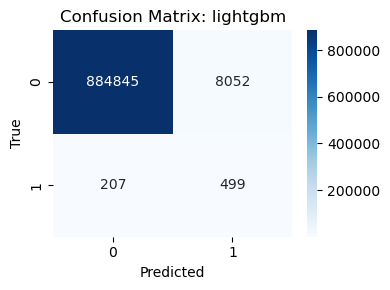

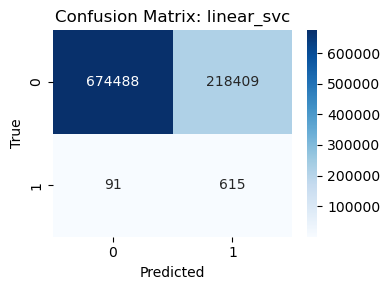

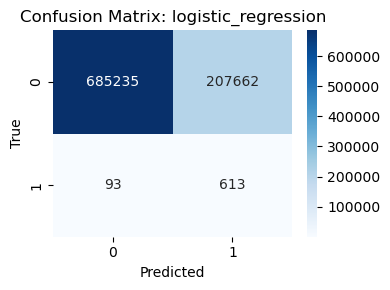

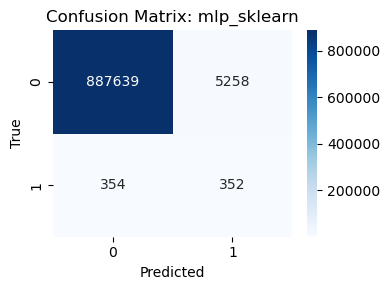

All plotting done. Plots saved in ./models_compare\plots


In [15]:
# Robust model-comparison & plotting cell (skip non-model pickles)
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix, precision_score, recall_score, f1_score
)

# ---------- CONFIG ----------
OUT_DIR = "./models_compare"   # change if you saved models elsewhere
PLOTS_DIR = os.path.join(OUT_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)
# ----------------------------

# Load test set if needed
try:
    X_test
    y_test
except NameError:
    test_path = "./processed/test.csv"
    if os.path.exists(test_path):
        test_df = pd.read_csv(test_path)
        y_test = test_df["label"].values
        X_test = test_df.drop(columns=["label","time"], errors="ignore")
        # If scaler exists in OUT_DIR, apply it to numeric columns
        scaler_path = os.path.join(OUT_DIR, "scaler_for_compare.pkl")
        if os.path.exists(scaler_path):
            scaler = pickle.load(open(scaler_path,"rb"))
            num_cols = X_test.select_dtypes(include=[np.number]).columns.tolist()
            X_test[num_cols] = scaler.transform(X_test[num_cols])
        print("Loaded test set from", test_path)
    else:
        raise RuntimeError("X_test and y_test not in memory and ./processed/test.csv not found. Please load test data first.")

# Helper: determine if object is a model-like (has predict or predict_proba or decision_function)
def is_model_like(obj):
    return any(hasattr(obj, attr) for attr in ("predict_proba", "decision_function", "predict"))

# Safe scoring routine
def model_scores(model, X):
    # returns (y_pred, score_for_auc_or_pr)
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        if proba.ndim == 2 and proba.shape[1] > 1:
            score = proba[:,1]
        else:
            score = proba.ravel()
        y_pred = (score >= 0.5).astype(int)
        return y_pred, score
    if hasattr(model, "decision_function"):
        score = model.decision_function(X)
        y_pred = (score >= 0).astype(int)
        return y_pred, score
    if hasattr(model, "predict"):
        y_pred = model.predict(X)
        # fallback score = predicted label (coarse)
        score = y_pred
        return y_pred, score
    raise AttributeError("Model has no predict/predict_proba/decision_function")

# Build list of candidate model files but skip known non-model files (scalers, label_map, etc.)
model_files = []
for f in os.listdir(OUT_DIR):
    if not f.endswith(".pkl"):
        continue
    # skip common non-model artifact names
    lower = f.lower()
    if any(k in lower for k in ("scaler", "label_map", "preprocess_summary", "summary")):
        continue
    model_files.append(f)

print("Candidate .pkl files considered for models:", model_files)

models = {}
metrics = []

for mf in model_files:
    path = os.path.join(OUT_DIR, mf)
    try:
        obj = pickle.load(open(path,"rb"))
    except Exception as e:
        print(f"Could not load {mf}: {e}")
        continue

    if not is_model_like(obj):
        print(f"Skipping {mf} (not model-like).")
        continue

    name = os.path.splitext(mf)[0]
    models[name] = obj
    try:
        y_pred, score = model_scores(obj, X_test)
    except Exception as e:
        print(f"Skipping {name} during scoring (error): {e}")
        continue

    prec_val = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec_val  = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1_val   = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    try:
        fpr, tpr, _ = roc_curve(y_test, score)
        roc_val = auc(fpr, tpr)
    except Exception:
        roc_val = np.nan
    try:
        ap_val = average_precision_score(y_test, score)
    except Exception:
        ap_val = np.nan

    metrics.append({
        "model": name,
        "precision_sybil": prec_val,
        "recall_sybil": rec_val,
        "f1_sybil": f1_val,
        "roc_auc": roc_val,
        "avg_precision": ap_val
    })
    print(f"Evaluated {name}: prec={prec_val:.4f} rec={rec_val:.4f} f1={f1_val:.4f} roc={roc_val:.4f} ap={ap_val:.4f}")

if not metrics:
    raise RuntimeError("No valid models found in OUT_DIR. Make sure you saved model .pkl files (and not just scalers).")

res_df = pd.DataFrame(metrics).set_index("model")
display(res_df)

# -------- Bar chart: precision/recall/f1 --------
plt.figure(figsize=(12,6))
res_df_sorted = res_df.sort_values("f1_sybil", ascending=False)
res_df_sorted[["precision_sybil","recall_sybil","f1_sybil"]].plot(kind="bar", rot=45, figsize=(12,6))
plt.title("Precision / Recall / F1 (Sybil class)")
plt.ylim(0,1.02)
plt.grid(axis="y")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "prf_bar.png"))
plt.show()

# -------- Bar chart: ROC-AUC & AP --------
plt.figure(figsize=(8,5))
res_df_sorted[["roc_auc","avg_precision"]].plot(kind="bar", rot=45, figsize=(8,5))
plt.title("ROC-AUC and Average Precision")
plt.ylim(0,1.02)
plt.grid(axis="y")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "auc_ap_bar.png"))
plt.show()

# -------- ROC & PR curves per model --------
plt.figure(figsize=(8,6))
for name, model in models.items():
    try:
        _, score = model_scores(model, X_test)
        fpr, tpr, _ = roc_curve(y_test, score)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
    except Exception as e:
        print("ROC skip", name, e)
plt.plot([0,1],[0,1],"k--", alpha=0.3)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "roc_comparison.png"))
plt.show()

plt.figure(figsize=(8,6))
for name, model in models.items():
    try:
        _, score = model_scores(model, X_test)
        prec, rec, _ = precision_recall_curve(y_test, score)
        plt.plot(rec, prec, label=f"{name} (AP={average_precision_score(y_test, score):.3f})")
    except Exception as e:
        print("PR skip", name, e)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "pr_comparison.png"))
plt.show()

# -------- Confusion matrices per model --------
for name, model in models.items():
    try:
        y_pred, _ = model_scores(model, X_test)
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix: {name}")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_DIR, f"cm_{name}.png"))
        plt.show()
    except Exception as e:
        print("CM skip", name, e)

print("All plotting done. Plots saved in", PLOTS_DIR)


,accuracy,precision_sybil,recall_sybil,f1_sybil,roc_auc,avg_precision
model,,,,,,
lightgbm,0.990758,0.058356,0.706799,0.107810,0.990867,0.195186
linear_svc,0.755484,0.002808,0.871105,0.005598,0.879807,0.005101
logistic_regression,0.767509,0.002943,0.868272,0.005867,0.880348,0.004974
mlp_sklearn,0.993720,0.062745,0.498584,0.111463,0.981859,0.079556


<Figure size 800x500 with 0 Axes>

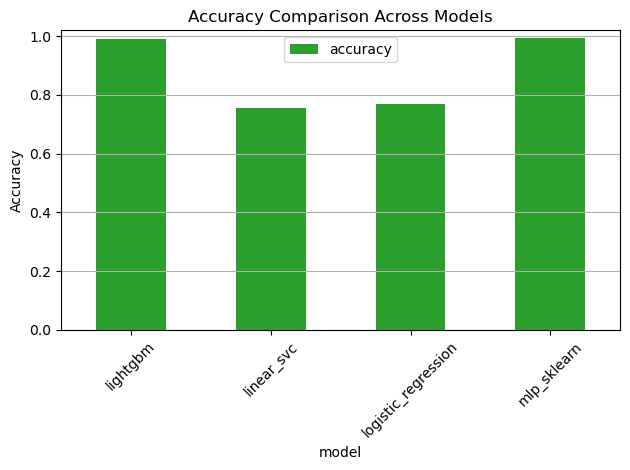

In [17]:
from sklearn.metrics import accuracy_score

# Recompute metrics (we already have models, X_test, y_test)
extra_metrics = []
for name, model in models.items():
    y_pred, score = model_scores(model, X_test)
    acc_val = accuracy_score(y_test, y_pred)
    prec_val = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec_val  = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1_val   = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    try:
        roc_val = auc(*roc_curve(y_test, score)[:2])
    except Exception:
        roc_val = np.nan
    try:
        ap_val = average_precision_score(y_test, score)
    except Exception:
        ap_val = np.nan

    extra_metrics.append({
        "model": name,
        "accuracy": acc_val,
        "precision_sybil": prec_val,
        "recall_sybil": rec_val,
        "f1_sybil": f1_val,
        "roc_auc": roc_val,
        "avg_precision": ap_val
    })

# Convert to DataFrame
res_df = pd.DataFrame(extra_metrics).set_index("model")
display(res_df)

# -------- Plot Accuracy Bar Chart --------
plt.figure(figsize=(8,5))
res_df[["accuracy"]].plot(kind="bar", rot=45, color="tab:green")
plt.title("Accuracy Comparison Across Models")
plt.ylabel("Accuracy")
plt.ylim(0,1.02)
plt.grid(axis="y")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "accuracy_bar.png"))
plt.show()
